# Eric Kofoid Assignment 5

In [1]:
require(fpp)

Loading required package: fpp
Loading required package: forecast
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: timeDate
This is forecast 7.1 

Loading required package: fma
Loading required package: tseries
Loading required package: expsmooth
Loading required package: lmtest


In [2]:
# read in the csv file
ds <- read.csv("../../pigs.csv", sep=",", header=TRUE)

# use zoo to convert the date "YYYY-MM" to a date
pigzoo <- read.zoo(ds, sep=",", FUN=as.yearmon)

# us ts to convert the zoo object to ts object using the correct intervals
pigs = ts(pigzoo, frequency=12, start=c(1980,1), end=c(1995, 8))

# 2)

I want to predict the next 10 months of data from Pigs. The following are the steps I took to do this.

## Examining Data (EDA)

First step is to check if my data is stationary. There is definitely seasonality in here and seems to be some trend too. The seasonality doesn't seem to vary much, so I don't think I have to perform mathematical transformations. The other types of transformations don't seem to be necessary either. I am going to perform DF test anyway to check for stationarity. The null hypo of the DF test is that the data is non-stationary. Since I have a large p-value it seems that I cannot reject the null hypo. This data is not stationary.

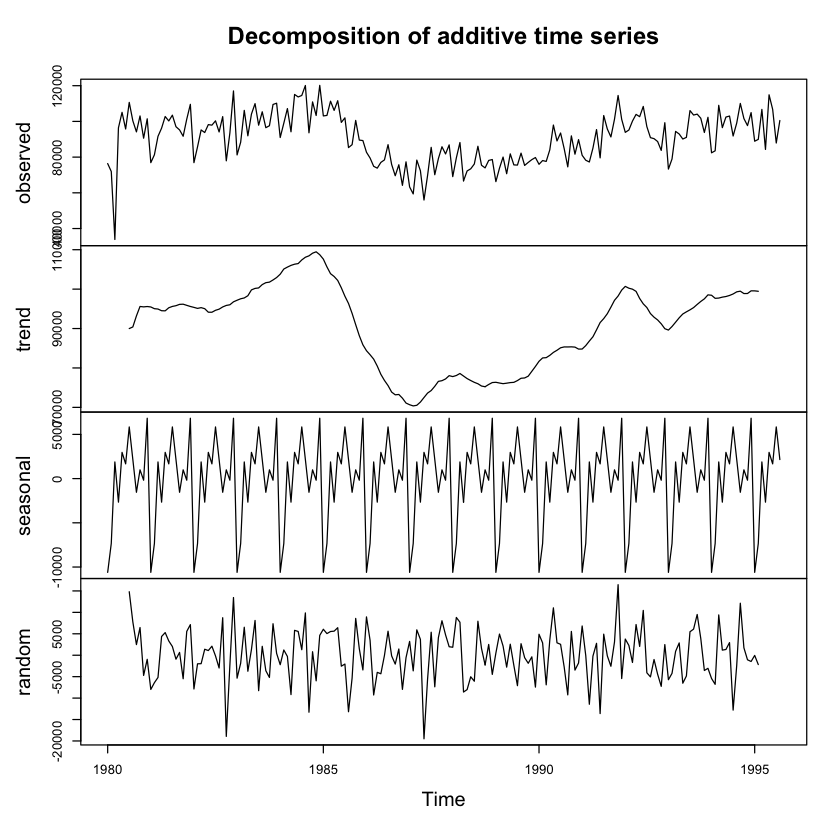

In [3]:
plot(decompose(pigs))

In [4]:
adf.test(pigs, alternative="stationary")


	Augmented Dickey-Fuller Test

data:  pigs
Dickey-Fuller = -2.1505, Lag order = 5, p-value = 0.5132
alternative hypothesis: stationary


## Look at differencing (Stationarity)

Maybe differencing will help make the data stationary.

The plot of the diff seems to have mean around 0 and variance around 0. So this is possibly stationary

The DF test shows that with first order differencing we can reject the null hypo that the data is non-stationary. It has a statistically significant p-value < 0.05. So it seems d=1 in ARIMA model will help us.

Warning message in adf.test(pigs_diff, alternative = "stationary"):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  pigs_diff
Dickey-Fuller = -8.3659, Lag order = 5, p-value = 0.01
alternative hypothesis: stationary


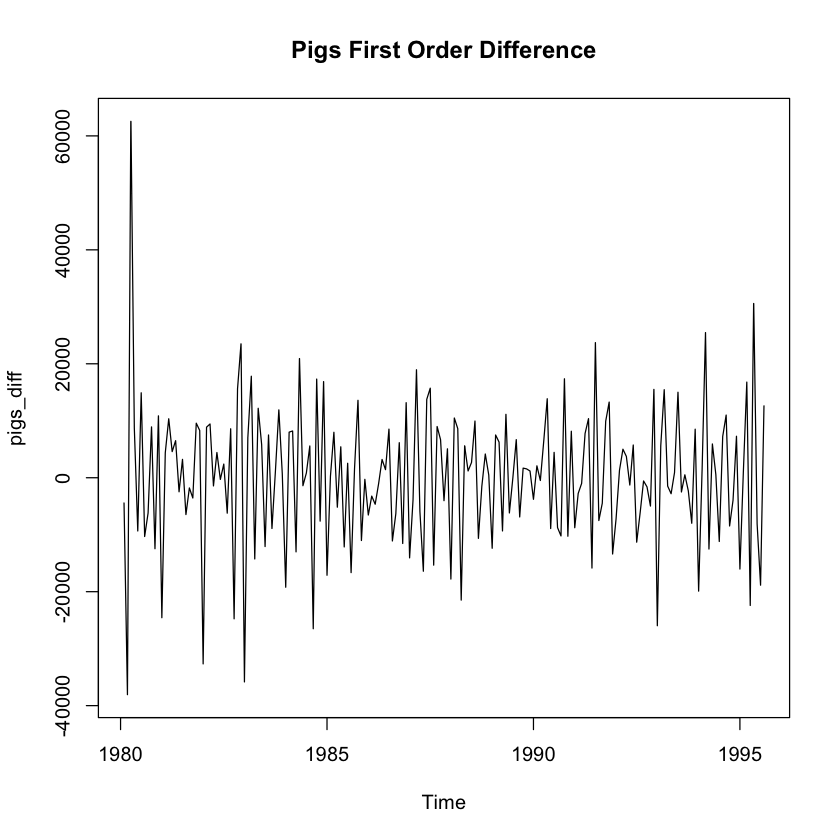

In [5]:
pigs_diff = diff(pigs)
plot(pigs_diff, main="Pigs First Order Difference")
adf.test(pigs_diff, alternative="stationary")

## What do ACF & PACF tell me about AR & MA

There is a significant spike in lag 1 of the ACF. The PACF is kind of sinualsoidal. So maybe this is AR(0) and MA(1) in the non-seasonal component.

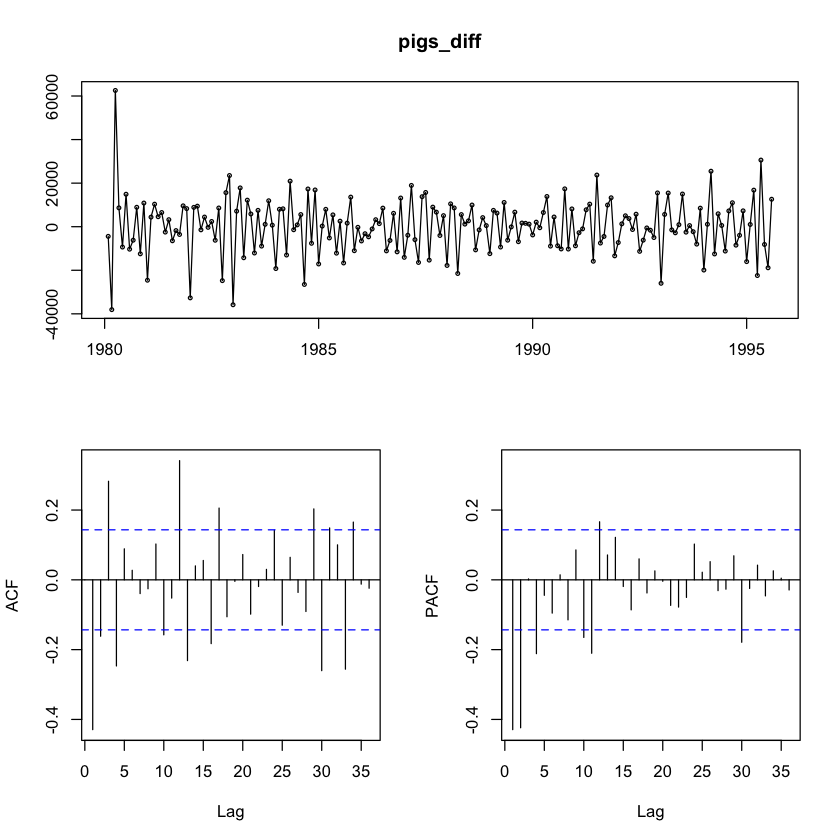

In [6]:
tsdisplay(pigs_diff)

## Try Auto ARIMA

What does Auto ARIMA give me?

It tells me that I have a difference order of 1, which is what I expected. My guess that the AR(0) is also correct since the p = 0. And my guess of MA(1) seems to be valid as well

Non-Seasonal part:
* p = 0
* d = 1
* q = 1

And there is a Seasonal Component as well, which I knew there should be:
* p = 1
* d = 0
* q = 0

In [7]:
aa_fit = auto.arima(pigs, approximation=FALSE, trace=FALSE)
summary(aa_fit)

Series: pigs 
ARIMA(0,1,1)(1,0,0)[12]                    

Coefficients:
          ma1    sar1
      -0.6587  0.4377
s.e.   0.0570  0.0773

sigma^2 estimated as 90639246:  log likelihood=-1979.04
AIC=3964.08   AICc=3964.21   BIC=3973.77

Training set error measures:
                   ME     RMSE      MAE        MPE    MAPE      MASE
Training set 233.6842 9444.198 7205.334 -0.7501757 8.35991 0.7209737
                     ACF1
Training set -0.002235655


## Check residuals

The residuals of both the ACF and PACF have significant spike at lag 3 and fairly high spike in 4. This makes me wonder if there is still something left in the non-seasonal portion of the model.

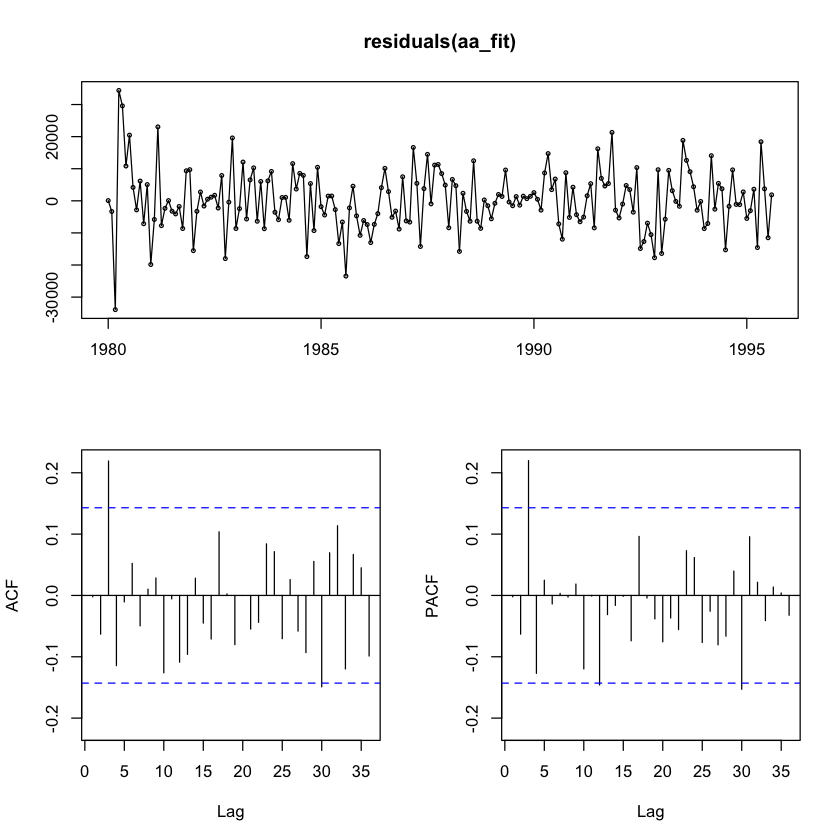

In [8]:
tsdisplay(residuals(aa_fit))

## Try Arima by hand

Since the last spike in ACF/PACF was almost at 4, I am going to try MA(4) in the non-seasonal portion of the arima model with the same seasonal part.

I have potentially found a little bit better model based on the AICc. The auto AICc = 3964.21, my hand model = 3956.31.

In [9]:
a4_fit = Arima(pigs, order=c(0, 1, 4), seasonal=c(1, 0, 0))
summary(a4_fit)

Series: pigs 
ARIMA(0,1,4)(1,0,0)[12]                    

Coefficients:
          ma1      ma2     ma3      ma4    sar1
      -0.6016  -0.1287  0.3095  -0.3062  0.4316
s.e.   0.0718   0.0871  0.0941   0.0948  0.0784

sigma^2 estimated as 85305511:  log likelihood=-1971.92
AIC=3955.84   AICc=3956.31   BIC=3975.23

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 295.1057 9087.519 6813.864 -0.6211828 7.897591 0.6818029
                   ACF1
Training set -0.0106162


## Check one more thing

I want to check to see if maybe I should have used MA(3).

Based on the AICc result, 4 is still the better choice.

In [10]:
a3_fit = Arima(pigs, order=c(0, 1, 3), seasonal=c(1, 0, 0))
summary(a3_fit)

Series: pigs 
ARIMA(0,1,3)(1,0,0)[12]                    

Coefficients:
          ma1      ma2     ma3    sar1
      -0.5909  -0.1469  0.1817  0.4451
s.e.   0.0787   0.1081  0.0903  0.0776

sigma^2 estimated as 89793658:  log likelihood=-1977.19
AIC=3964.39   AICc=3964.72   BIC=3980.54

Training set error measures:
                   ME     RMSE      MAE        MPE     MAPE      MASE
Training set 149.3429 9349.092 7013.648 -0.7741344 8.132867 0.7017934
                    ACF1
Training set -0.02935138


## Check residuals

Lastly, I want to check the results to see if they are white noise. All the lags are within the band of confidence, I have white noise

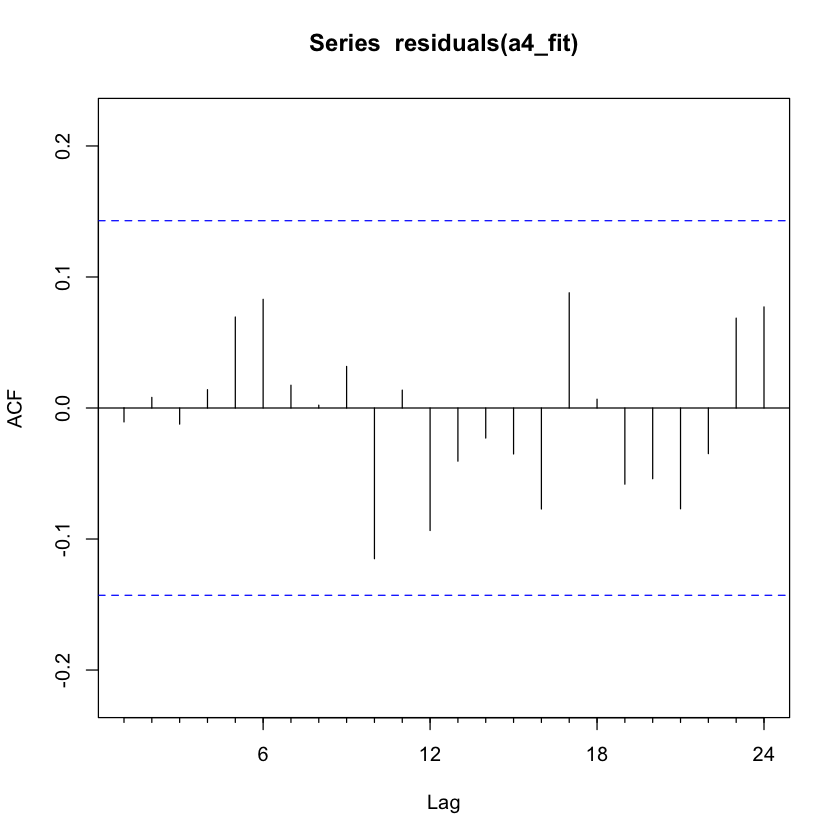

In [11]:
Acf(residuals(a4_fit))

# Predict 10 months out

After all that I want to see my results. Looks like we won't be killing as many pigs as we have been. Good thing for the pigs.

I am pretty impressed with the results of this. After a few larger variations in peaks and troughs, there have been some smaller ones. This model is predicting that the next 10 months will have smaller variation. Maybe this is some sort of cycle???

In [12]:
future = forecast(a4_fit, 10)

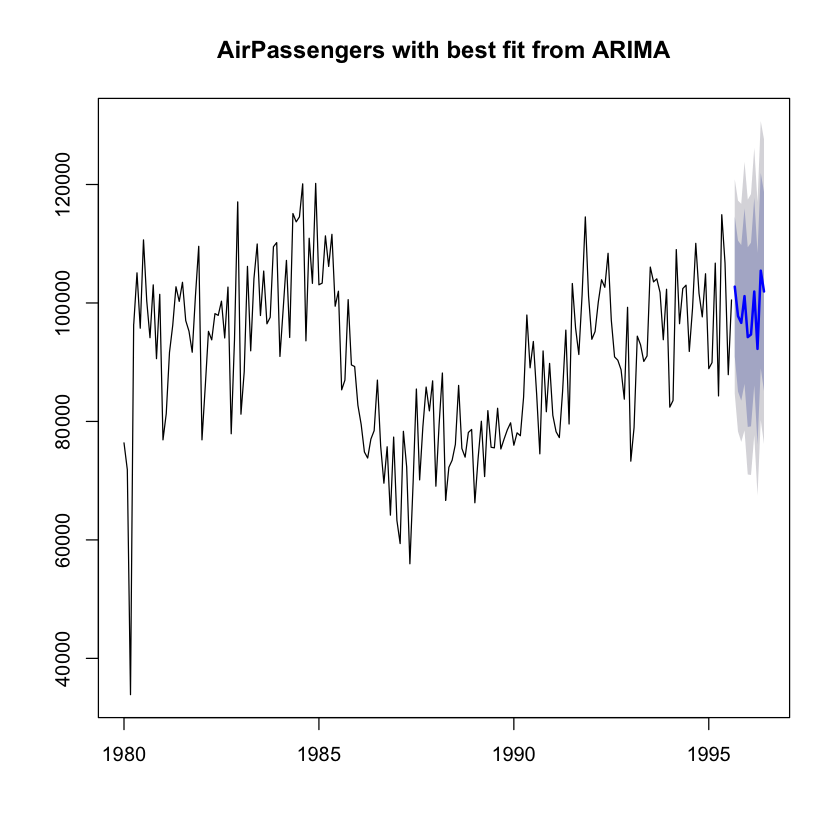

In [13]:
plot(future, main="AirPassengers with best fit from ARIMA")